## Company Sales Revenue Analysis (2012 - 2022) and Forecasting (2023 - 2027)

In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Company Sales

In [2]:
#Reading the data to file
dfs = pd.read_excel("sales_df.xlsx")

In [3]:
#Drop all null values
dfs.dropna(inplace = True)

In [4]:
#Display the last five rows of the data
dfs.tail()

Unnamed: 0     ID Account Businees Unit    Year  Scenario Month  \
463       463.0  464.0   Sales   Advertising  2023.0    Budget   Dec   
464       464.0  465.0   Sales      Hardware  2023.0    Budget   Dec   
465       465.0  466.0   Sales      Software  2023.0  Forecast   Dec   
466       466.0  467.0   Sales   Advertising  2023.0  Forecast   Dec   
467       467.0  468.0   Sales      Hardware  2023.0  Forecast   Dec   

           Sales      Date  
463  23499890.91  Dec 2023  
464  34814653.20  Dec 2023  
465  71434962.00  Dec 2023  
466  16430041.26  Dec 2023  
467  26430935.94  Dec 2023

In [5]:
#Display the unique values of the Scenario column - 
dfs["Scenario"].unique()

array(['Actuals', 'Budget', 'Forecast'], dtype=object)

In [6]:
#Drop the irrelvant columns
dfs.drop(columns = ["Unnamed: 0", "ID"], inplace = True)

In [7]:
#Drop null values
dfs.dropna(inplace = True)

In [8]:
# Filter out rows where the Scenario column is equal to "Budget"
dfs_ = dfs[dfs["Scenario"] != "Budget"]

In [9]:
# Filter out rows where the Scenario column is equal to "Forecast"
dfs_f = dfs_[dfs_["Scenario"] != "Forecast"]

In [10]:
#Check for unique values of the column to be sure its Actual Sales values only
dfs_f["Scenario"].unique()

array(['Actuals'], dtype=object)

In [11]:
# Convert the 'Date' column to datetime
dfs_f['Date'] = pd.to_datetime(dfs_f['Date'], format='%b %Y')

In [12]:
#Make a copy of the data frame
dfs_f1 = dfs_f.copy()

In [13]:
#Slice and get a subset of the data frame to set for the forecasting analysis
dfs_f1 = dfs_f1[["Date", "Sales"]]

In [14]:
#Read the first five rows of the new data frame
dfs_f1.head()

Date        Sales
0 2012-01-01  90924002.00
1 2012-01-01  20003280.44
2 2012-01-01  32732640.72
3 2013-01-01  62935397.00
4 2013-01-01  15104495.28

In [15]:
#Show the earliest date
dfs_f1["Date"].min()

Timestamp('2012-01-01 00:00:00')

In [16]:
#Show the latest date - most recent
dfs_f1["Date"].max()

Timestamp('2022-12-01 00:00:00')

In [17]:
# Creating a date range with monthly frequency
# 'start' defines the beginning of the date range ('2012-01-01')
# 'end' defines the end of the date range ('2022-12-01')
# 'freq = 'M'' specifies that the frequency is monthly
date = pd.date_range(start='2012-01-01', end='2022-12-01', freq='M')

# Displaying the generated date range
date

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31',
               ...
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', length=131, freq='M')

In [18]:
# Drop rows with index 132 and above
dfs_f1 = dfs_f1.drop(dfs_f1.index[131:])

In [19]:
# Assign the 'date' variable to a new column called 'month' in the DataFrame 'df'
dfs_f1['month'] = date

# Drop the 'Date' column from the DataFrame 'df', with 'axis=1' specifying column-wise drop,
# and 'inplace=True' ensuring that the change is applied directly to the original DataFrame
dfs_f1.drop('Date', axis=1, inplace=True)

# Set the 'month' column as the new index for the DataFrame 'df'
dfs_f1 = dfs_f1.set_index('month')

# Display the first five rows of the modified DataFrame to verify changes
dfs_f1.head()

Sales
month                  
2012-01-31  90924002.00
2012-02-29  20003280.44
2012-03-31  32732640.72
2012-04-30  62935397.00
2012-05-31  15104495.28

### Exploratory Data Analysis of Sales

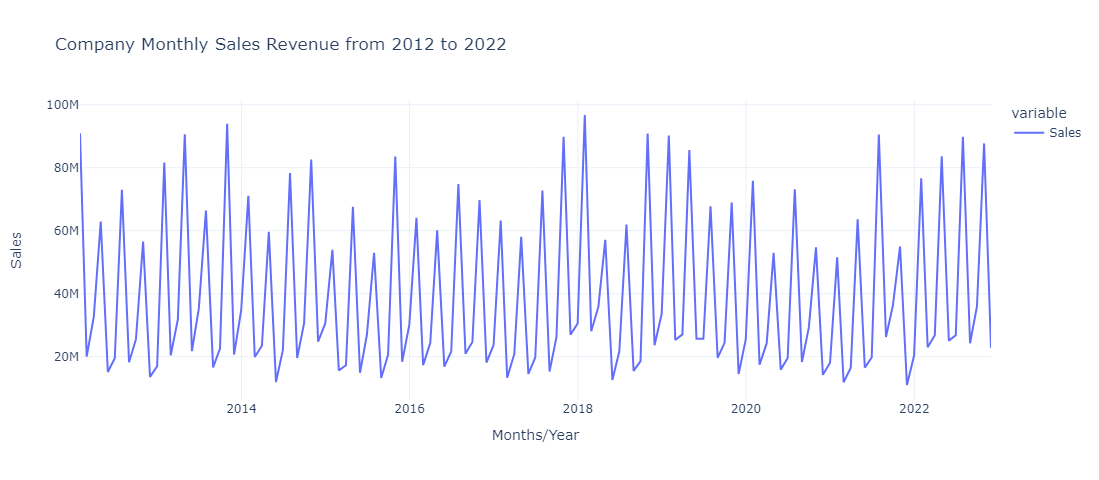

In [20]:
import plotly.express as px

# Replot using Plotly
fig = px.line(dfs_f1, 
              title="Company Monthly Sales Revenue from 2012 to 2022", 
              labels={"index": "Months", "value": "Sales"})

# Update layout for better visualization
fig.update_layout(
    xaxis_title="Months/Year",
    yaxis_title="Sales",
    width=1200,  # equivalent to 20 inches in width
    height=480,  # equivalent to 8 inches in height
    template="plotly_white"  # optional: use a clean, white background
)

# Show the plot
fig.show()

The graph shows the monthly sales revenue of the company from 2012 to 2022. The sales revenue fluctuates significantly over this period, ranging from 20 to over 90 million dollars. This indicates variability in the company’s performance, with some months showing higher sales and others lower. The overall trend can help in analyzing business performance, identifying seasonal trends, or evaluating the impact of specific events on sales.

In [21]:
#Show a statistial view of Comapany Sales
round(dfs_f1.describe(),2)

Sales
count       131.00
mean   39013539.18
std    25697896.58
min    10998962.60
25%    19618262.04
50%    25680201.90
75%    61042418.50
max    96747422.00

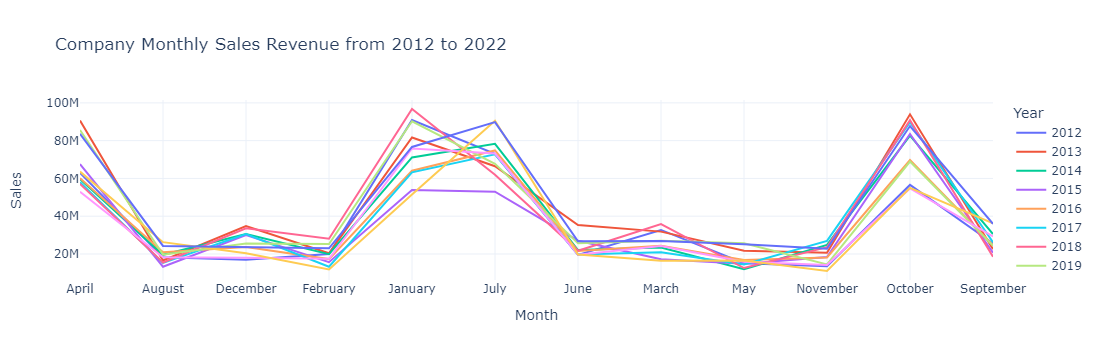

In [22]:
# If you have a DateTime index, you can extract the month and year
dfs_f1['Month'] = dfs_f1.index.month_name()
dfs_f1['Year'] = dfs_f1.index.year

# If 'dfs_f1' already has separate 'month' and 'year' columns, skip the above step

# Now, group the data by month for each year and calculate the mean or sum as needed
monthly_data = dfs_f1.groupby(['Month', 'Year']).mean().reset_index()

# Sort the months in calendar order for plotting
monthly_data['Month'] = pd.Categorical(monthly_data['Month'], 
                                       categories=['January', 'February', 'March', 'April', 'May', 
                                                   'June', 'July', 'August', 'September', 
                                                   'October', 'November', 'December'], 
                                       ordered=True)

# Create the Plotly figure
fig = px.line(monthly_data, 
              x='Month', 
              y=monthly_data.columns[2],  # Assuming the sales data is in the 3rd column
              color='Year',
              labels={'y':'Sales'}, 
              title='Company Monthly Sales Revenue from 2012 to 2022')

# Customize the layout to resemble the previous matplotlib plot
fig.update_layout(xaxis_title='Month',
                  yaxis_title='Sales',
                  xaxis=dict(tickmode='array', 
                             tickvals=['January', 'February', 'March', 'April', 'May', 
                                       'June', 'July', 'August', 'September', 
                                       'October', 'November', 'December']),
                  template='plotly_white')

# Show the plot
fig.show()

The graph shows the monthly sales revenue of a company from 2012 to 2022. The sales revenue fluctuates significantly over this period, ranging from 0 to 100 million dollars. This indicates variability in the company’s performance, with some months showing higher sales and others lower.

#### High Sales Years:

2014: This year shows a significant peak in sales, especially around mid-year.

2018: Another strong year with consistently high sales throughout most months.

#### Low Sales Years:

2015: This year experienced several dips, with notably lower sales in the first half.

2020: Sales were quite variable, with some months showing significant drops, possibly due to external factors like the global pandemic.

the graph does show some seasonality and recurring patterns in the company’s sales revenue:

#### Seasonal Peaks: 

There are noticeable increases in sales during certain months across multiple years. For example, sales tend to peak around mid-year (June to August) and towards the end of the year (November to December). This could be due to seasonal demand, holidays, or promotional events.

####Recurring Lows: 
    
Similarly, there are recurring dips in sales during the early months of the year (January to March) and sometimes in the middle of the year (April to May). These periods might reflect post-holiday slowdowns or other seasonal factors.
Identifying these patterns can be useful for planning marketing strategies, inventory management, and resource allocation to maximize sales during peak periods and mitigate the impact of slower months.

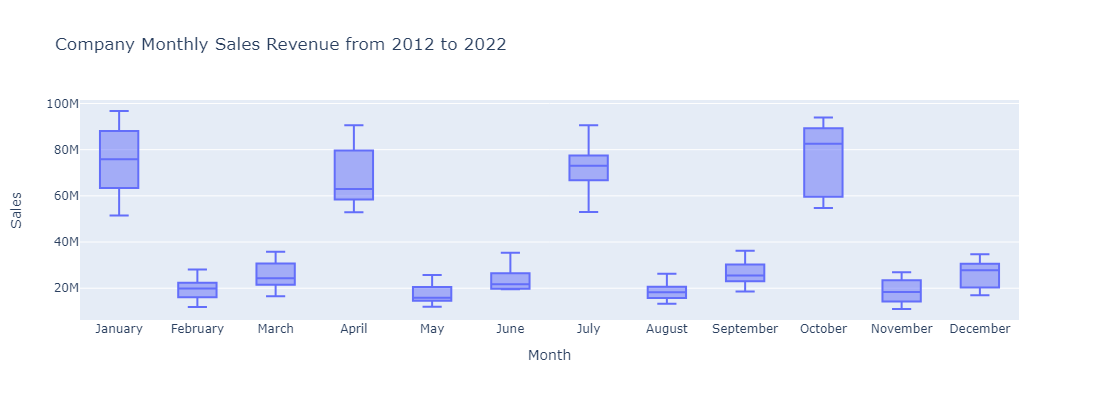

In [23]:
# First, extract the month names and create a new DataFrame
dfs_f1['Month'] = dfs_f1.index.month_name()
dfs_f1['Sales'] = dfs_f1.values[:, 0]  # assuming the sales data is in the first column

# Create a boxplot using Plotly
fig = px.box(dfs_f1, x='Month', y='Sales', 
             title='Company Monthly Sales Revenue from 2012 to 2022', 
             labels={'Month': 'Month', 'Sales': 'Sales'},
             width=1000, height=400)

# Show the plot
fig.show()

The graph is a box plot showing the company’s monthly sales revenue from 2012 to 2022. Each box represents the distribution of sales for a particular month over these ten years. 

The key points are:

Median: The line inside each box shows the median sales for that month.
                                                       
Interquartile Range (IQR): The box itself represents the middle 50% of the data.
                                                       
Whiskers: The lines extending from the boxes show the range of the data, excluding outliers.
                                                       
This visualization helps identify patterns and variations in sales across different months, highlighting any seasonal trends. For example, months January, Aprl, July and October are consistently higher, which indicates stronger sales during those periods.

In [24]:
# Split the DataFrame into a training set and a test set based on the year

# Select the data where the year is less than or equal to 2020 and assign it to the training set
train = dfs_f1[dfs_f1.index.year <= 2020]

# Select the data where the year is greater than 2020 and assign it to the test set
test = dfs_f1[dfs_f1.index.year > 2020]

In [25]:
# Print the dimensions (rows and columns) of the training dataset
print(train.shape)

# Print the dimensions (rows and columns) of the test dataset
print(test.shape)

(108, 3)
(23, 3)


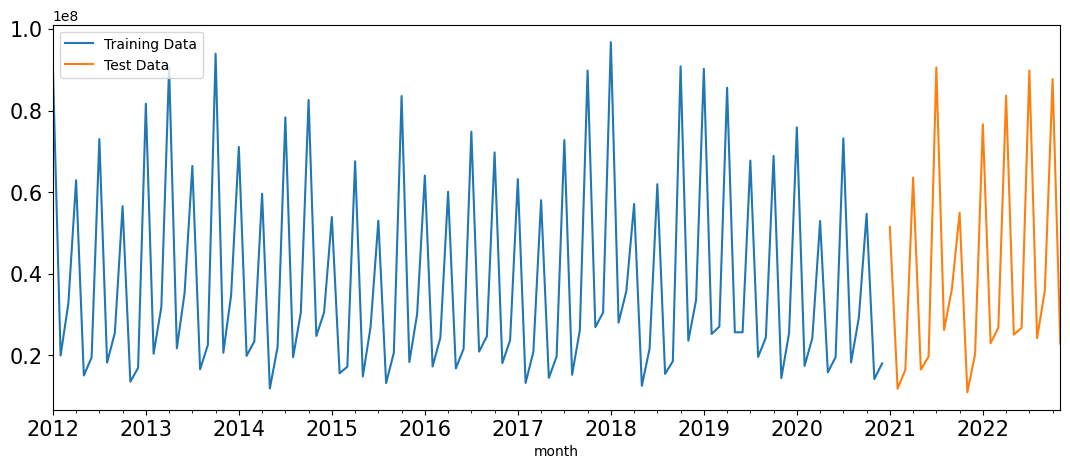

In [26]:
# Plot the 'Price' column from the 'train' DataFrame
train["Sales"].plot(figsize=(13, 5), fontsize=15)

# Plot the 'Price' column from the 'test' DataFrame on the same figure
test["Sales"].plot(figsize=(13, 5), fontsize=15)

# Add a legend to the plot to differentiate between training and test data
plt.legend(['Training Data', 'Test Data'])

# Display the plot
plt.show()

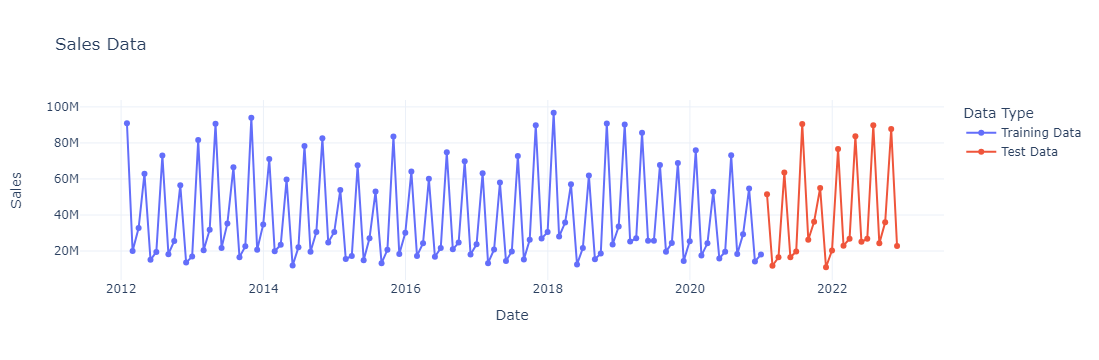

In [27]:
import plotly.graph_objs as go
# Create a Plotly figure
fig = go.Figure()

# Add the training data trace
fig.add_trace(go.Scatter(
    x=train.index,
    y=train['Sales'],
    mode='lines+markers',
    name='Training Data'
))
# Add the test data trace
fig.add_trace(go.Scatter(
    x=test.index,
    y=test['Sales'],
    mode='lines+markers',
    name='Test Data'
))
# Update the layout with titles and legends
fig.update_layout(
    title='Sales Data',
    xaxis_title='Date',
    yaxis_title='Sales',
    legend_title='Data Type',
    template='plotly_white'
)
# Show the plot
fig.show()

In [28]:
# Generate a list of time indices for the training data.
# The time index starts at 1 and increments by 1 for each entry in the 'train' dataset.
train_time = [i+1 for i in range(len(train))]

# Generate a list of time indices for the test data.
# The time index starts right after the last index of the training data.
# It begins at len(train) + 1 and increments by 1 for each entry in the 'test' dataset.
test_time = [i+len(train)+1 for i in range(len(test))]

# Calculate the lengths of the 'train_time' and 'test_time' lists
# and return these lengths as a tuple.
len(train_time), len(test_time)

(108, 23)

In [29]:
# Create a copy of the 'train' DataFrame and assign it to 'LR_train'. # This is done to preserve the original 'train' data while allowing
# modifications to 'LR_train' without affecting the original 'train' DataFrame.
LR_train = train.copy()

# Create a copy of the 'test' DataFrame and assign it to 'LR_test'. # This allows you to modify 'LR_test' for further analysis or processing
# without altering the original 'test' data.
LR_test = test.copy()

In [30]:
# Assign the generated time indices from the train_time list to a new column 'time' in the LR_train DataFrame
LR_train["time"] = train_time

# Assign the generated time indices from the test_time list to a new column 'test' in the LR_test DataFrame
LR_test["test"] = test_time

#### Build and fit a linear regression model

In [31]:
# Import the LinearRegression class from sklearn
lr = LinearRegression()  # Initialize the LinearRegression model

# Fit the model using the training data
# LR_train[['time']] is the feature (independent variable), and LR_train['Price'].values is the target (dependent variable)
lr.fit(LR_train[['time']], LR_train["Sales"].values)

LinearRegression()

In [32]:
# Creating a new column 'time' in the LR_test DataFrame
# The 'time' column will contain sequential values starting from 1
# It uses a list comprehension to generate the sequence: [1, 2, 3, ..., len(LR_test)]
LR_test['time'] = [i+1 for i in range(len(LR_test))]

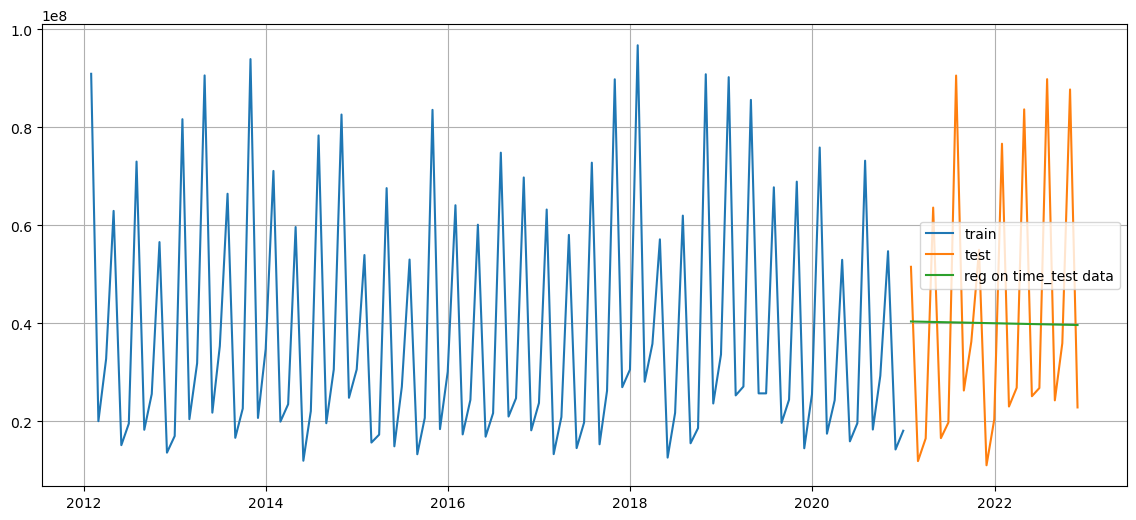

In [33]:
# Generate predictions using the trained linear regression model `lr` on the `LR_test` dataset
# The model is predicting based on the 'time' feature
test_predictions_model1 = lr.predict(LR_test[["time"]])

# Add the predicted values to the `LR_test` DataFrame under a new column named 'forecast'
LR_test['forecast'] = test_predictions_model1

# Create a new figure for plotting with a specified size (14x6 inches)
plt.figure(figsize=(14, 6))

# Plot the 'Price' column from the `train` DataFrame
# This represents the actual prices for the training data
plt.plot(train['Sales'], label='train')

# Plot the 'Price' column from the `test` DataFrame
# This represents the actual prices for the test data
plt.plot(test['Sales'], label='test')

# Plot the 'forecast' column from the `LR_test` DataFrame
# This represents the predicted prices from the model based on the 'time' feature in the test data
plt.plot(LR_test['forecast'], label='reg on time_test data')

# Add a legend to the plot to identify the different lines
plt.legend(loc='best')

# Add grid lines to the plot for better readability
plt.grid()

# Display the plot
plt.show()

In [34]:
def mape(actual, pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

    Parameters:
    actual (array-like): Array or list of actual values.
    pred (array-like): Array or list of predicted values.

    Returns:
    float: The MAPE value, rounded to two decimal places.
    """
    # Compute the absolute errors between actual and predicted values
    abs_errors = abs(actual - pred)
    
    # Compute the percentage errors by dividing absolute errors by actual values
    percentage_errors = abs_errors / actual
    
    # Calculate the mean of the percentage errors
    mean_percentage_error = np.mean(percentage_errors)
    
    # Convert the mean percentage error to a percentage and round to two decimal places
    mape_value = round(mean_percentage_error * 100, 2)
    
    return mape_value

##### Code Explanation

This function calculates the Mean Absolute Percentage Error (MAPE) between actual and predicted values. Here’s a summary:

Parameters:

actual: Array or list of actual values.

pred: Array or list of predicted values.

Process:

Computes the absolute errors between actual and predicted values.

Converts these absolute errors to percentage errors by dividing by the actual values.

Calculates the mean of these percentage errors.

Converts the mean percentage error to a percentage and rounds it to two decimal places.

Returns:

The MAPE value as a float, rounded to two decimal places.

This metric helps evaluate the accuracy of predictions by showing the average percentage error.

In [35]:
# Calculate the Mean Absolute Percentage Error (MAPE) for model1 on the test dataset
# `test['Price'].values` contains the actual price values from the test dataset
# `test_predictions_model1` contains the predicted values from the model
mape_model1_test = mape(test['Sales'].values, test_predictions_model1)

# Print the MAPE value formatted to three decimal places
# The MAPE value is the average percentage error between the actual and predicted values
print("MAPE is %3.3f" % (mape_model1_test), "%")

MAPE is 77.640 %


In [36]:
# Create a DataFrame with one row and one column
results = pd.DataFrame({
    'Test Mape (%)': [mape_model1_test]  # The column 'Test Mape (%)' contains the value of MAPE for model 1 on test data
}, index=["RegressionOnTime"])  # Set the index of the DataFrame to 'RegressionOnTime'

# Display the DataFrame
results

Test Mape (%)
RegressionOnTime          77.64

In [37]:
# Create a copy of the 'train' DataFrame and store it in 'Naive_train'
Naive_train = train.copy()

# Create a copy of the 'test' DataFrame and store it in 'Naive_test'
Naive_test = test.copy()

In [38]:
# Assign the last value of the 'Price' column from the 'train' DataFrame to the 'naive' column in the 'Naive_test' DataFrame.
Naive_test['naive'] = np.asarray(train['Sales'])[len(np.asarray(train['Sales']))-1]

# Display the first few entries of the 'naive' column in the 'Naive_test' DataFrame.
Naive_test['naive'].head()

month
2021-01-31    18053347.95
2021-02-28    18053347.95
2021-03-31    18053347.95
2021-04-30    18053347.95
2021-05-31    18053347.95
Name: naive, dtype: float64

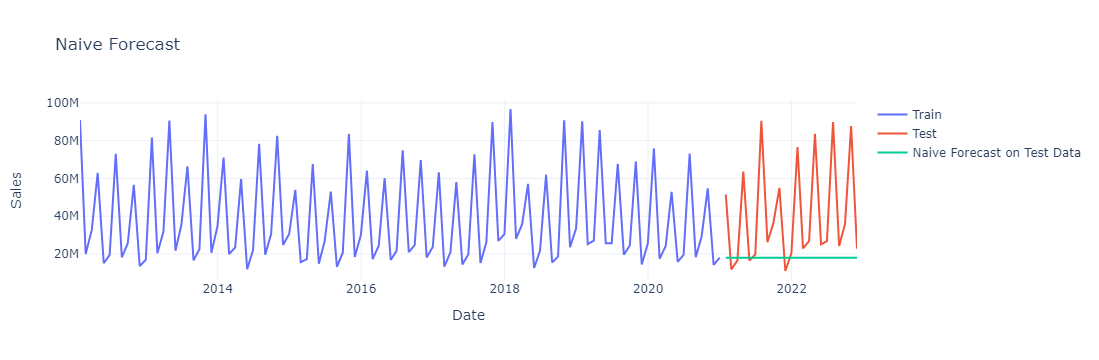

In [39]:
import plotly.graph_objs as go

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for the 'Train' data from the Naive_train DataFrame
fig.add_trace(go.Scatter(x=Naive_train.index, y=Naive_train['Sales'], mode='lines', name='Train'))

# Add a line trace for the 'Test' data from the test DataFrame
fig.add_trace(go.Scatter(x=test.index, y=test['Sales'], mode='lines', name='Test'))

# Add a line trace for the 'Naive Forecast on Test Data' from the Naive_test DataFrame
fig.add_trace(go.Scatter(x=Naive_test.index, y=Naive_test['naive'], mode='lines', name='Naive Forecast on Test Data'))

# Set the title of the plot
fig.update_layout(title="Naive Forecast",
                  xaxis_title="Date",
                  yaxis_title="Sales",
                  template='plotly_white')

# Display grid lines on the plot for better readability
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Show the plot
fig.show()

In [40]:
# Calculate the Mean Absolute Percentage Error (MAPE) for the Naive forecast model on the test data.
# The `mape` function computes the MAPE between the actual prices (`test['Price'].values`) 
# and the predicted values from the Naive forecast model (`Naive_test['naive'].values`).

mape_model2_test = mape(test['Sales'].values, Naive_test['naive'].values)

# Print the calculated MAPE value for the Naive forecast model on the test data.
# The %3.3f format specifier ensures that the MAPE is printed with three decimal places.
# The "%" at the end adds a percentage sign to the output.
print("For Naive forecast on Test Data, MAPE is %3.3f" % (mape_model2_test), "%")

For Naive forecast on Test Data, MAPE is 45.450 %


In [41]:
# Create a DataFrame with a single entry:
# 'Test MAPE (%)' is the column name, and [mape_model2_test] is the value for this column.
# The index for this entry is 'NaiveModel'.
resultsDf_2 = pd.DataFrame({'Test MAPE (%)' : [mape_model2_test]}, index=['NaiveModel'])

# Concatenate the new DataFrame (resultsDf_2) with an existing DataFrame (results).
# This operation combines rows from both DataFrames, appending resultsDf_2 to results.
results = pd.concat([results, resultsDf_2])

# Display the updated DataFrame 'results' which now includes the new row with MAPE values.
results

Test Mape (%)  Test MAPE (%)
RegressionOnTime          77.64            NaN
NaiveModel                  NaN          45.45

In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ensure 'Sales' column is numerical
dfs_f1['Sales'] = pd.to_numeric(dfs_f1['Sales'], errors='coerce')

# Handle missing values
dfs_f1['Sales'] = dfs_f1['Sales'].fillna(method='ffill')  # Forward fill missing values

# Extract time series
time_series = dfs_f1['Sales']

# Fit Exponential Smoothing model
model = ExponentialSmoothing(time_series, trend='additive', seasonal='additive')
final_model = model.fit(smoothing_level=0.1, smoothing_trend=0.1, smoothing_seasonal=0.1)

# Output model summary
print(final_model.summary())

                         ExponentialSmoothing Model Results                        
Dep. Variable:                    Sales   No. Observations:                     131
Model:             ExponentialSmoothing   SSE                 11829990291653162.000
Optimized:                         True   AIC                              4241.582
Trend:                         Additive   BIC                              4287.586
Seasonal:                      Additive   AICC                             4247.690
Seasonal Periods:                    12   Date:                    Thu, 29 Aug 2024
Box-Cox:                          False   Time:                            07:17:58
Box-Cox Coeff.:                    None                                            
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1000000                alpha                Fals

In [43]:
# Define the MAPE (Mean Absolute Percentage Error) function
def mape(actual, forecast):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and forecasted values.

    Parameters:
    - actual: Array-like, the actual observed values.
    - forecast: Array-like, the predicted values from the model.

    Returns:
    - MAPE: The Mean Absolute Percentage Error expressed as a percentage.
    """
    # Compute the mean of the absolute percentage errors
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Calculate MAPE for the final model
# Here 'df['Price'].values' contains the actual observed prices
# 'final_model.fittedvalues' contains the forecasted values from the model
MAPE_final_model = mape(dfs_f1['Sales'].values, final_model.fittedvalues)

# Print the calculated MAPE value to evaluate the model's accuracy
print("MAPE:", MAPE_final_model)

MAPE: 20.24450530480613


Purpose: This function calculates the Mean Absolute Percentage Error (MAPE), which is a measure of prediction accuracy in a forecasting model.
    
Parameters:

actual: The actual observed values.
    
forecast: The predicted values from the model.

Returns: The MAPE value, expressed as a percentage.


The MAPE function helps you understand the accuracy of your forecasting model by showing the average percentage error between the actual and predicted values. A MAPE value of 20.2% means that the model’s predictions are, on average, 20.2% off from the actual values.

#### General Interpretation

Lower MAPE: Indicates higher accuracy. The model’s predictions are closer to the actual values.
    
Higher MAPE: Indicates lower accuracy. The model’s predictions deviate more from the actual values.
    
#### Specific Ranges

0% - 10%: Excellent forecasting accuracy.

10% - 20%: Good forecasting accuracy.

20% - 50%: Reasonable forecasting accuracy.

Above 50%: Poor forecasting accuracy.

#### Our Case
With a MAPE value of 20.2%, your model’s accuracy is considered reasonable. This means that, on average, the forecasted values are about 20.2% off from the actual values. While this is not perfect, it indicates that the model is fairly reliable but could still be improved.

In [44]:
# Forecast the future values based on the final model.
# 'steps' specifies the number of time steps to forecast ahead, which is equal to the length of the 'test' dataset.
prediction = final_model.forecast(steps=len(test))

In [45]:
prediction.head()

2022-12-31    3.406339e+07
2023-01-31    8.115140e+07
2023-02-28    2.817807e+07
2023-03-31    3.511065e+07
2023-04-30    7.862273e+07
Freq: M, dtype: float64

In [46]:
# Set the precision to 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

In [47]:
# Create a DataFrame to store the forecast predictions along with their confidence intervals
pred_df = pd.DataFrame({
    # Calculate the lower bound of the confidence interval
    'lower_CI': prediction - 1.96 * np.std(final_model.resid, ddof=1),
    
    # Store the predicted values
    'prediction': prediction,
    
    # Calculate the upper bound of the confidence interval
    'upper_CI': prediction + 1.96 * np.std(final_model.resid, ddof=1)
})

# Display the first few rows of the DataFrame to verify its contents
pred_df.head()

lower_CI  prediction    upper_CI
2022-12-31 15393705.35 34063385.32 52733065.29
2023-01-31 62481723.71 81151403.68 99821083.65
2023-02-28  9508385.66 28178065.63 46847745.60
2023-03-31 16440968.92 35110648.89 53780328.86
2023-04-30 59953052.06 78622732.03 97292412.00

In [48]:
forecast_steps = 5 * 12  # for monthly data for 5 years

# Forecast the future values based on the final model
prediction = final_model.forecast(steps=forecast_steps)

# Create a date range for the forecast period
# Assuming the index of 'test' is of DateTimeIndex type and the data is monthly
last_date = test.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]  # Generate future dates

# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame(data={'prediction': prediction}, index=forecast_index)

# Display the forecast DataFrame
forecast_df.tail()

prediction
2027-07-31 119080092.19
2027-08-31  66007338.15
2027-09-30  74460398.01
2027-10-31 123385443.78
2027-11-30  67868348.76

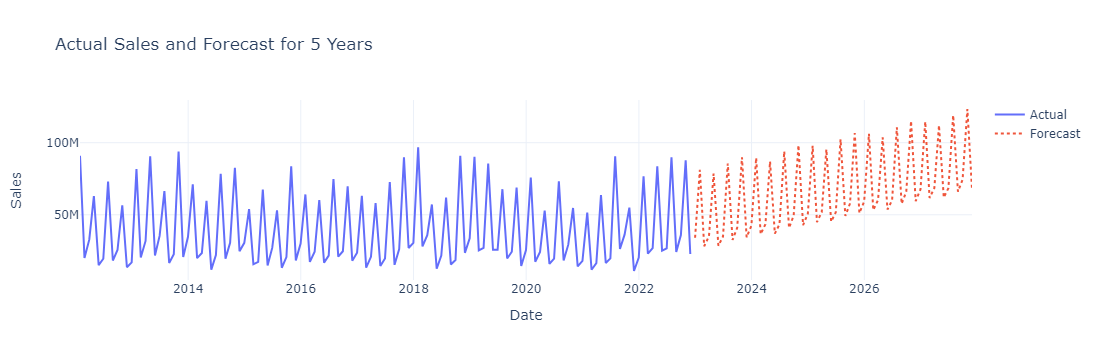

In [49]:
import plotly.graph_objs as go

# Define the number of steps to forecast (e.g., 60 months for monthly data)
forecast_steps = 5 * 12  # for monthly data

# Forecast the future values based on the final model
prediction = final_model.forecast(steps=forecast_steps)

# Create a date range for the forecast period
last_date = test.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]  # Generate future dates

# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame(data={'prediction': prediction}, index=forecast_index)

# Create a Plotly figure
fig = go.Figure()

# Add the actual data trace
fig.add_trace(go.Scatter(x=dfs_f1.index, y=dfs_f1['Sales'], mode='lines', name='Actual'))

# Add the forecasted data trace
fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['prediction'], mode='lines', name='Forecast', line=dict(dash='dot')))

# Update layout for titles and axis labels
fig.update_layout(
    title='Actual Sales and Forecast for 5 Years',
    xaxis_title='Date',
    yaxis_title='Sales',
    template='plotly_white'
)

# Show the plot
fig.show()

The graph titled “Actual Sales and Forecast for 5 Years” shows the sales performance over time, with both historical data and future projections.

#### Key Elements:
    
Horizontal Axis (Date): Spans from 2013 to beyond 2026.

Vertical Axis (Sales): Ranges from 0 to 100 million (presumably in monetary units).
                                                     
Lines on the Graph:

Solid Blue Line: Represents actual sales data.
    
Dashed Red Line: Represents forecasted sales.

#### Observations:
    
Historical Sales:

The solid blue line shows fluctuations in sales over time, with a general upward trend until around 2021.
This indicates growth in sales with some variability.
    
#### Forecasted Sales:
    
After 2021, the dashed red line continues, indicating projected sales.
    
The forecast shows an upward trend, suggesting expected growth in sales.

#### Business Implications:

Historical Performance: The actual sales data helps in understanding past performance, identifying trends, and making informed decisions.

Future Projections: The forecasted sales provide insights into expected future performance, aiding in strategic planning, budgeting, and resource allocation.

### Summary:
This project analyzes the company's sales revenue from 2012 to 2022, identifying key trends and seasonal patterns, such as peak sales during mid-year and year-end periods. A forecast using an Exponential Smoothing model predicts continued growth from 2023 to 2027, providing valuable insights for strategic planning and decision-making. The report underscores the importance of understanding past performance and preparing for future challenges to ensure sustained success.